# Data Missing Value Analysis  

 
This notebook investigates missing data patterns in British Airways and Emirates review datasets using multiple statistical and visual tests.  

- **Missingness quantification:** counts and % per column.  
- **Visualization tests:** Missingno matrix, bar chart, and heatmap to inspect structure and correlations.  
- **Correlation analysis:** correlations between missingness flags across variables.  
- **Chi-Square tests:** checked associations between missingness and categorical features (e.g., seat type, traveller type, route, recommendation).  
- **Logistic regression test:** modeled probability of missingness from travel-related predictors and reported significance (p-values, AUC).  

Therefore ,Classified missingness as **MCAR vs. MAR** and highlighted variables needing imputation or exclusion before modeling.  


In [17]:
!pip install missingno

In [18]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

In [19]:
import pandas as pd

# File paths
ba_path = r"C:\Users\Samiksha\Documents\Dissertataion python\2BA_with_sentiment.csv"
em_path = r"C:\Users\Samiksha\Documents\Dissertataion python\2Em_with_sentiment.csv"

# Load datasets
ba_df = pd.read_csv(ba_path)
em_df = pd.read_csv(em_path)

# Quick check
print("British Airways dataset shape:", ba_df.shape)
print("Emirates dataset shape:", em_df.shape)

British Airways dataset shape: (3218, 35)
Emirates dataset shape: (1475, 35)


## Missing values

In [21]:
# Count nulls for all columns
ba_df.isna().sum()

overall_rating             1
review_title               0
review_date                0
verified_flag              0
review_text                0
travel_type              288
travel_class               2
route                      0
travel_date              295
seat_comfort             115
staff_service            126
ground_service           363
value_for_money            0
recommended                0
aircraft                1296
food_quality             385
entertainment           1140
wifi                    2609
airline                    0
origin                   292
destination              308
origin_raw               292
stopover_raw            2711
destination_raw          292
origin_coords            293
stopover_coords         2711
destination_coords       294
distance_km              295
flight_category            0
review_text_clean          0
sentiment_label            0
sentiment_confidence       0
score_neg                  0
score_neu                  0
score_pos     

# 1] Missingness Analysis Function (plot_missingness)

- **Print summary table:**  
  - Displays count of missing values per column, sorted descending.  

- **Matrix plot (`msno.matrix`):**  
  - Black/white visualization of missing vs. non-missing entries across rows.  
  - Helps spot row-level patterns (e.g., entire rows missing a group of features).  

- **Bar chart (`msno.bar`):**  
  - Bar graph of missingness per column (absolute & %).  
  - Quickly highlights which features have the most missing data.  

- **Correlation heatmap (`msno.heatmap`):**  
  - Computes correlations between missingness of columns.  
  - for *MAR*  


--- Missingness for British Airways ---
wifi                    2609
aircraft                1296
entertainment           1140
food_quality             385
ground_service           363
travel_date              295
travel_type              288
staff_service            126
seat_comfort             115
travel_class               2
overall_rating             1
airline                    0
sentiment_label            0
review_text_clean          0
flight_category            0
sentiment_confidence       0
score_neg                  0
score_neu                  0
recommended                0
review_title               0
value_for_money            0
route                      0
review_text                0
verified_flag              0
review_date                0
score_pos                  0
dtype: int64


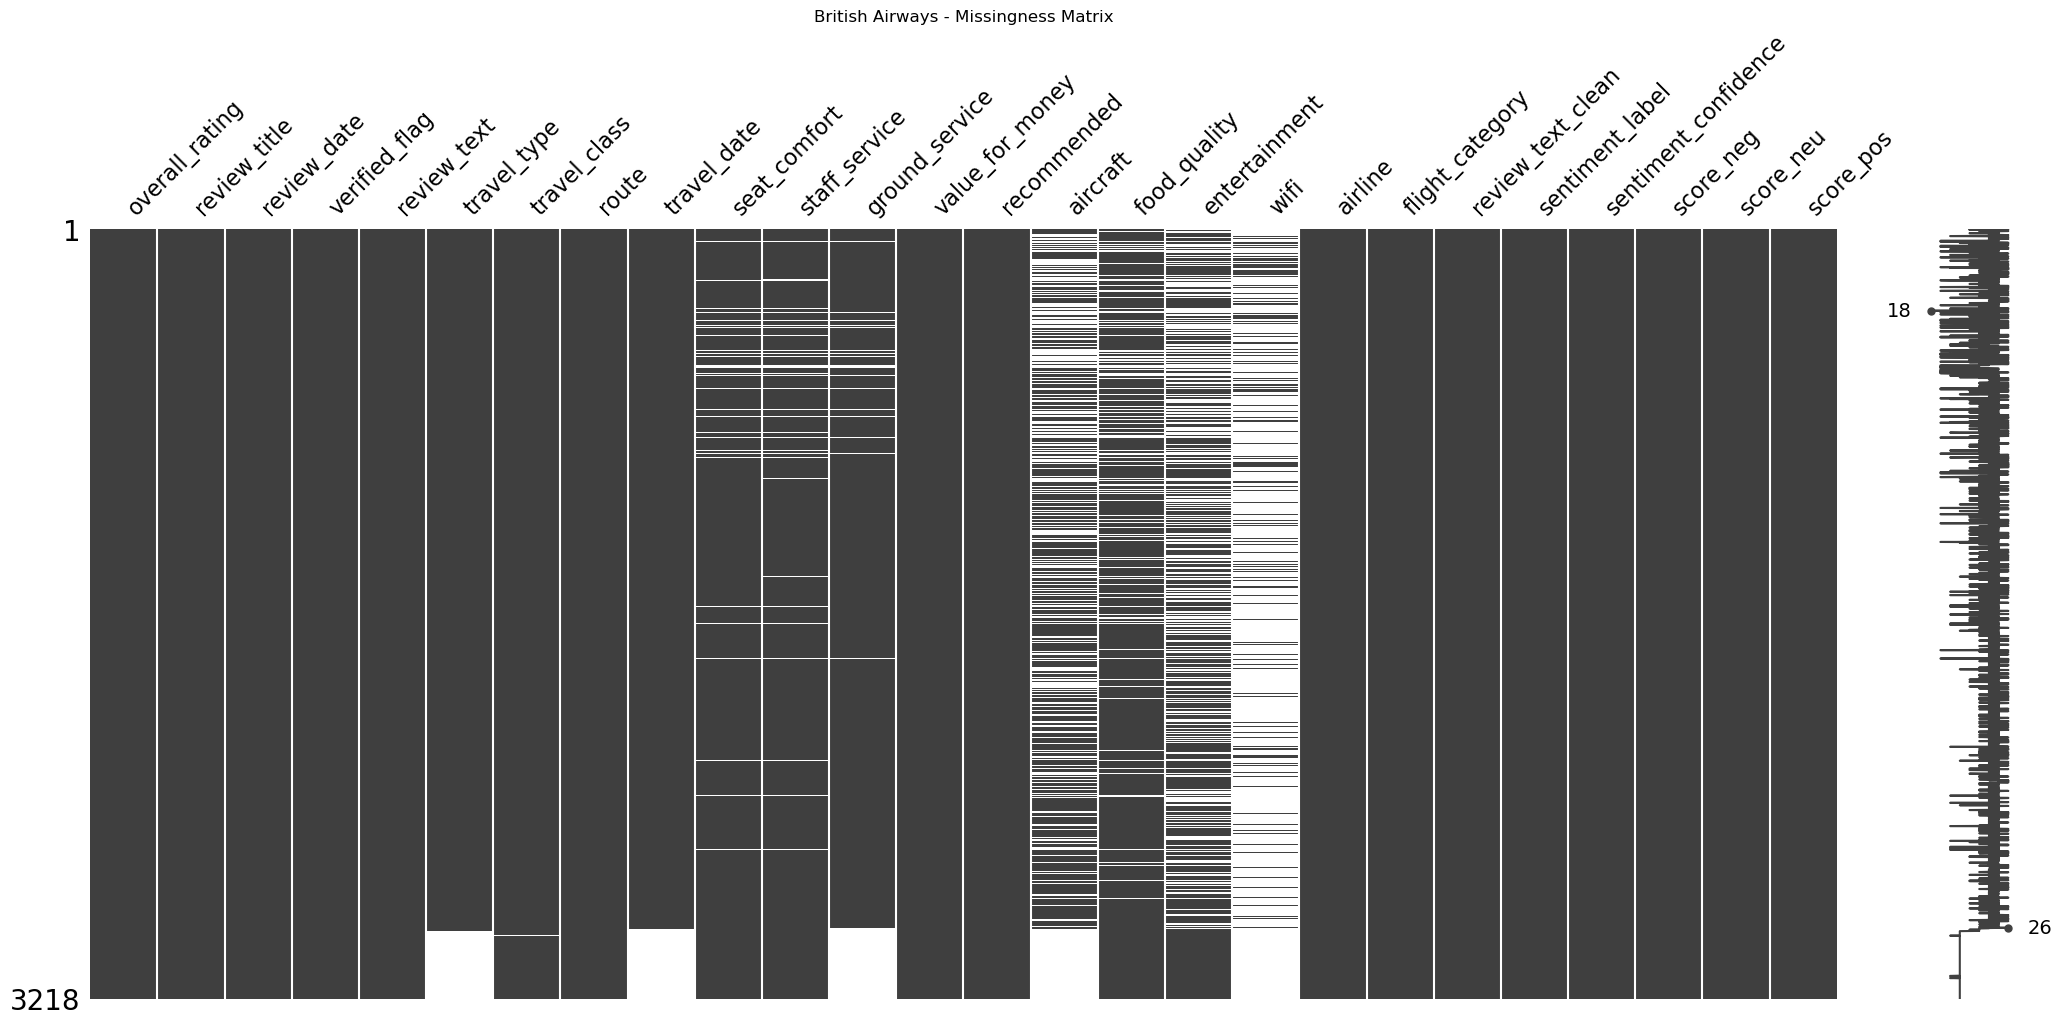

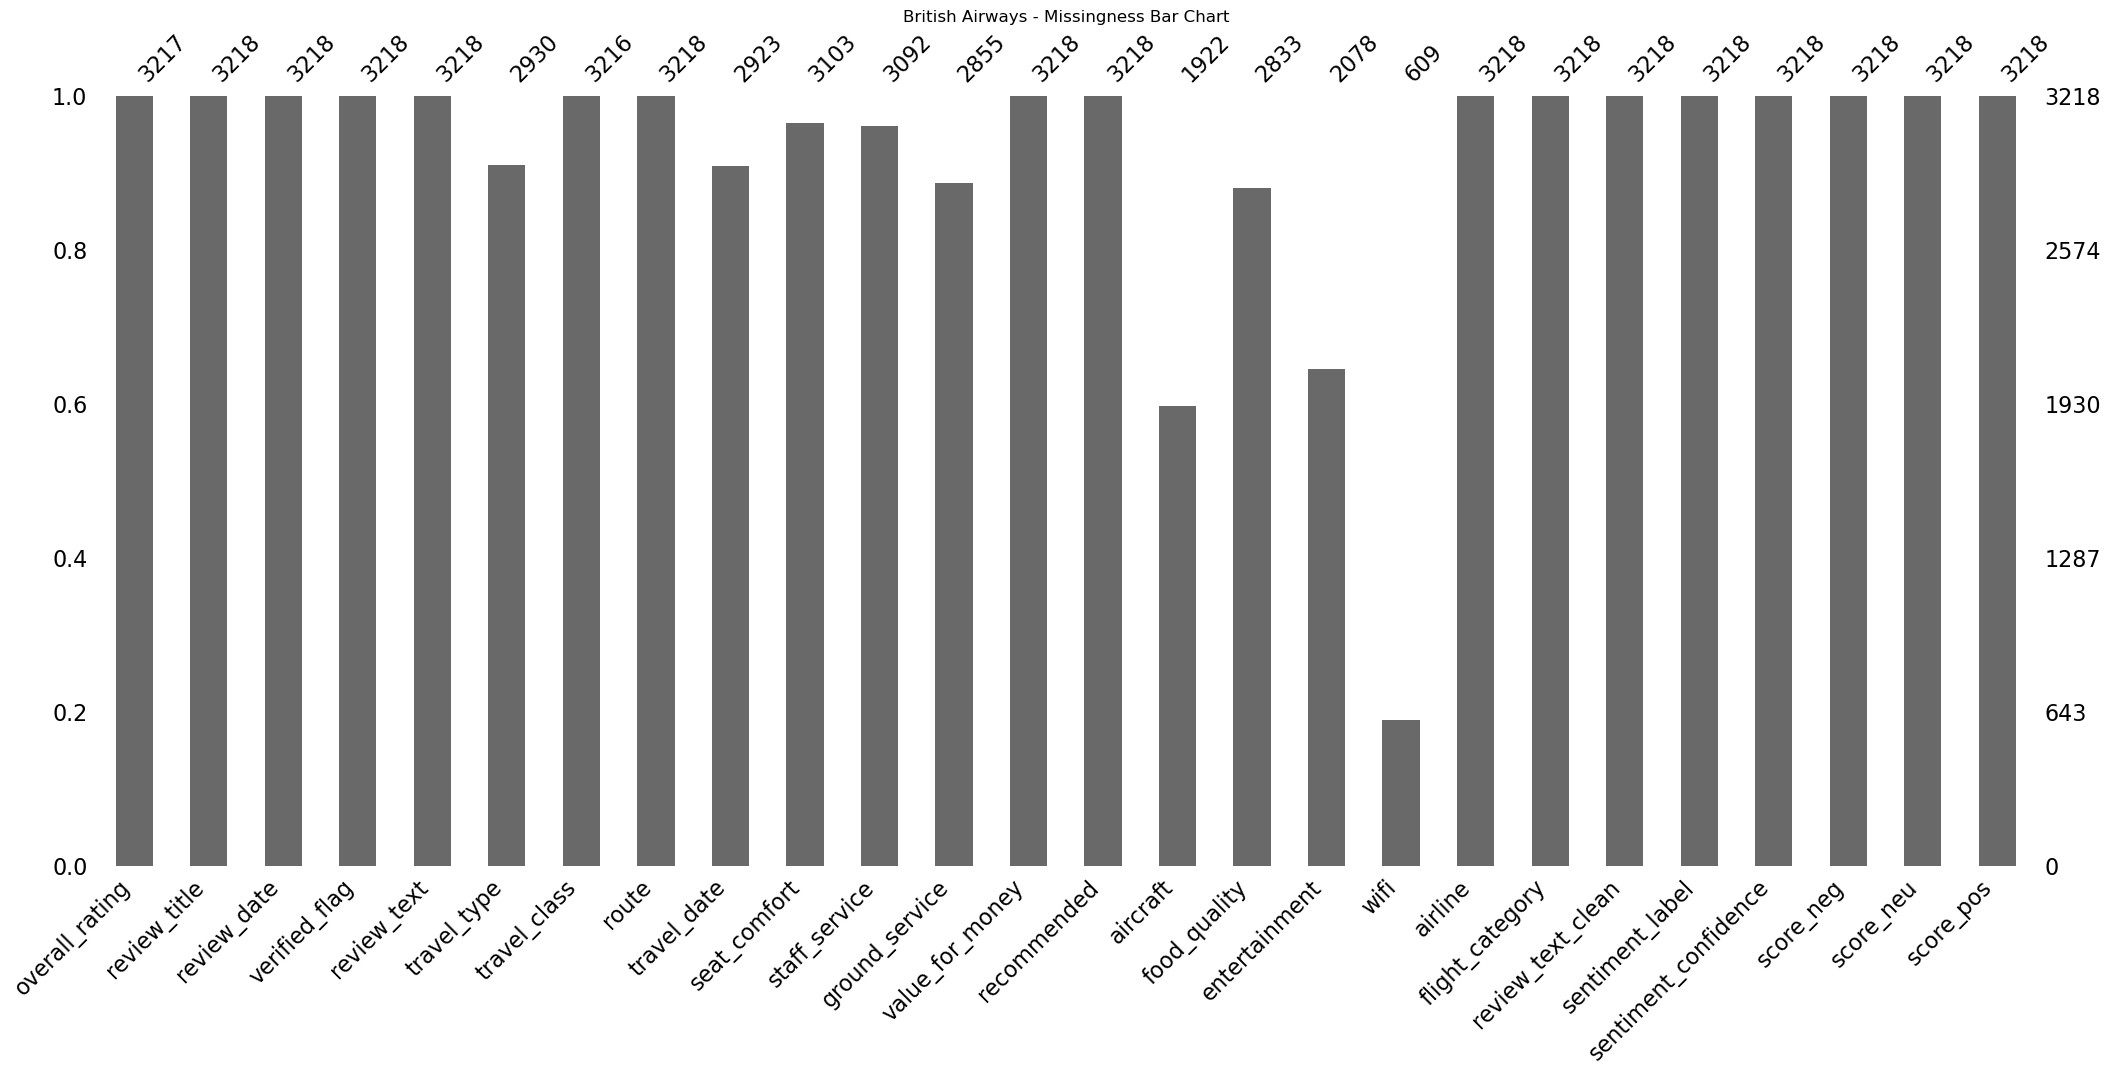

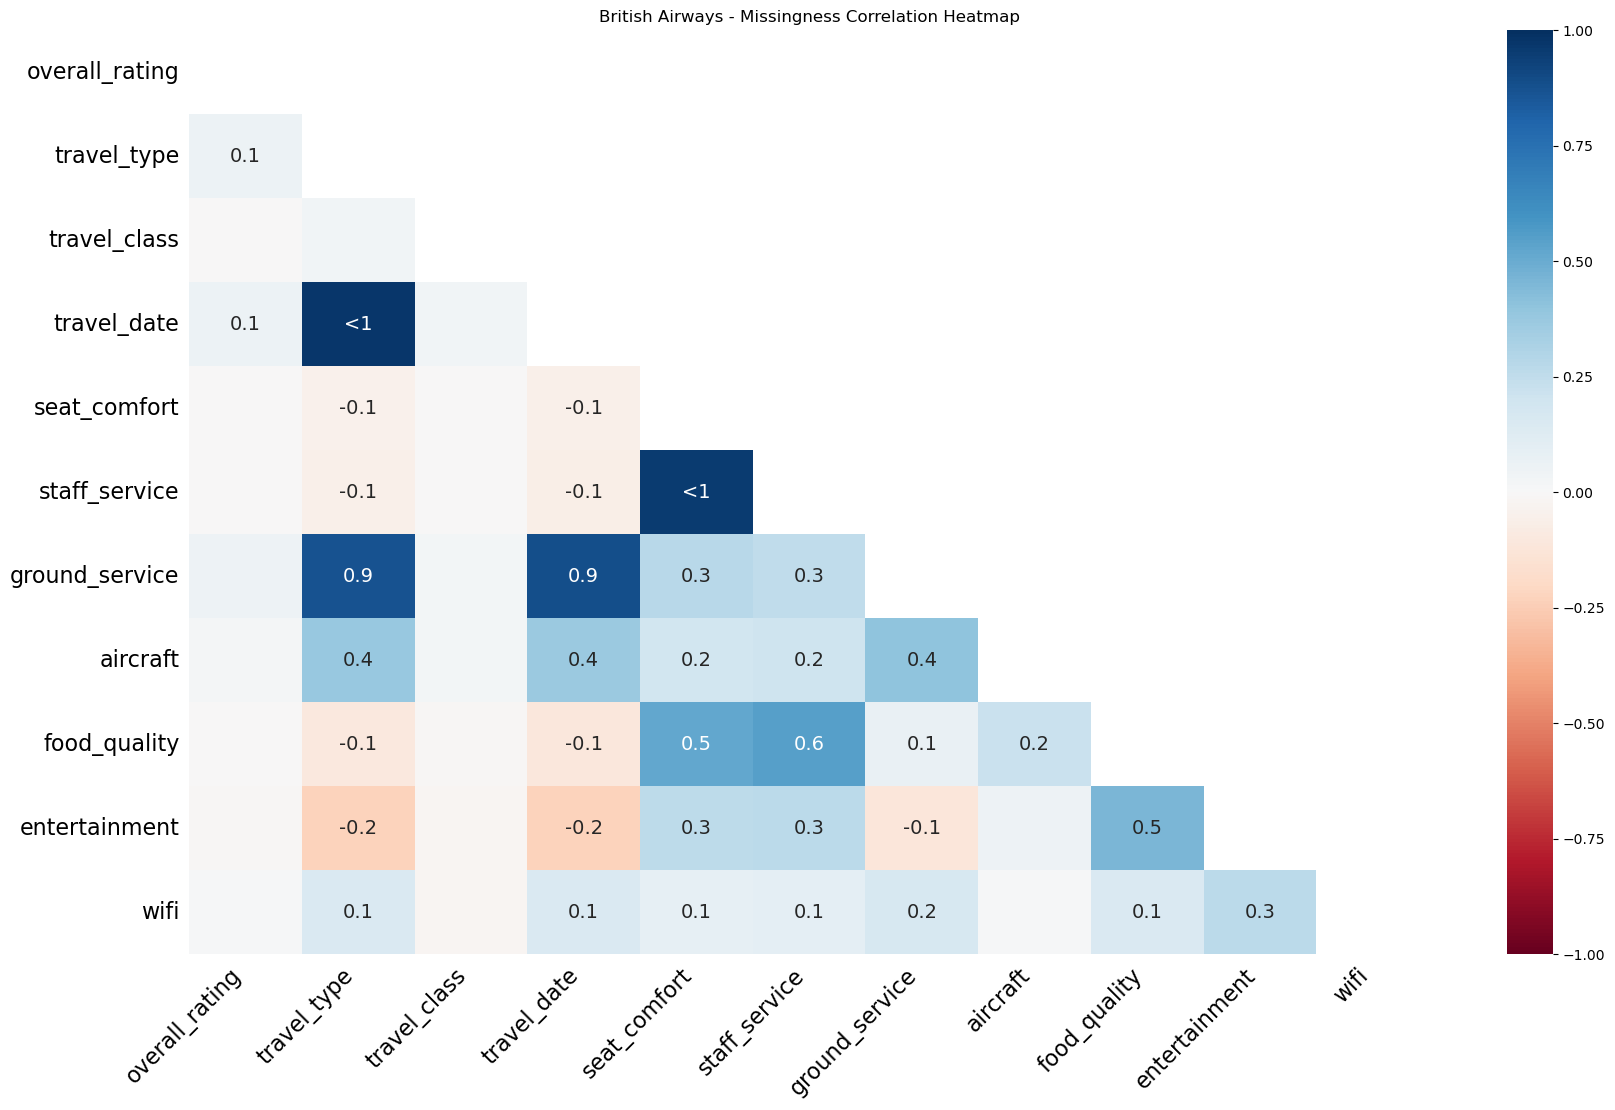


--- Missingness for Emirates Airways ---
wifi                    579
aircraft                464
entertainment           151
verified_flag           142
food_quality            115
staff_service            60
seat_comfort             59
ground_service           37
review_text               0
score_neu                 0
score_neg                 0
sentiment_confidence      0
sentiment_label           0
review_text_clean         0
flight_category           0
airline                   0
review_title              0
overall_rating            0
recommended               0
value_for_money           0
review_date               0
travel_date               0
route                     0
travel_class              0
travel_type               0
score_pos                 0
dtype: int64


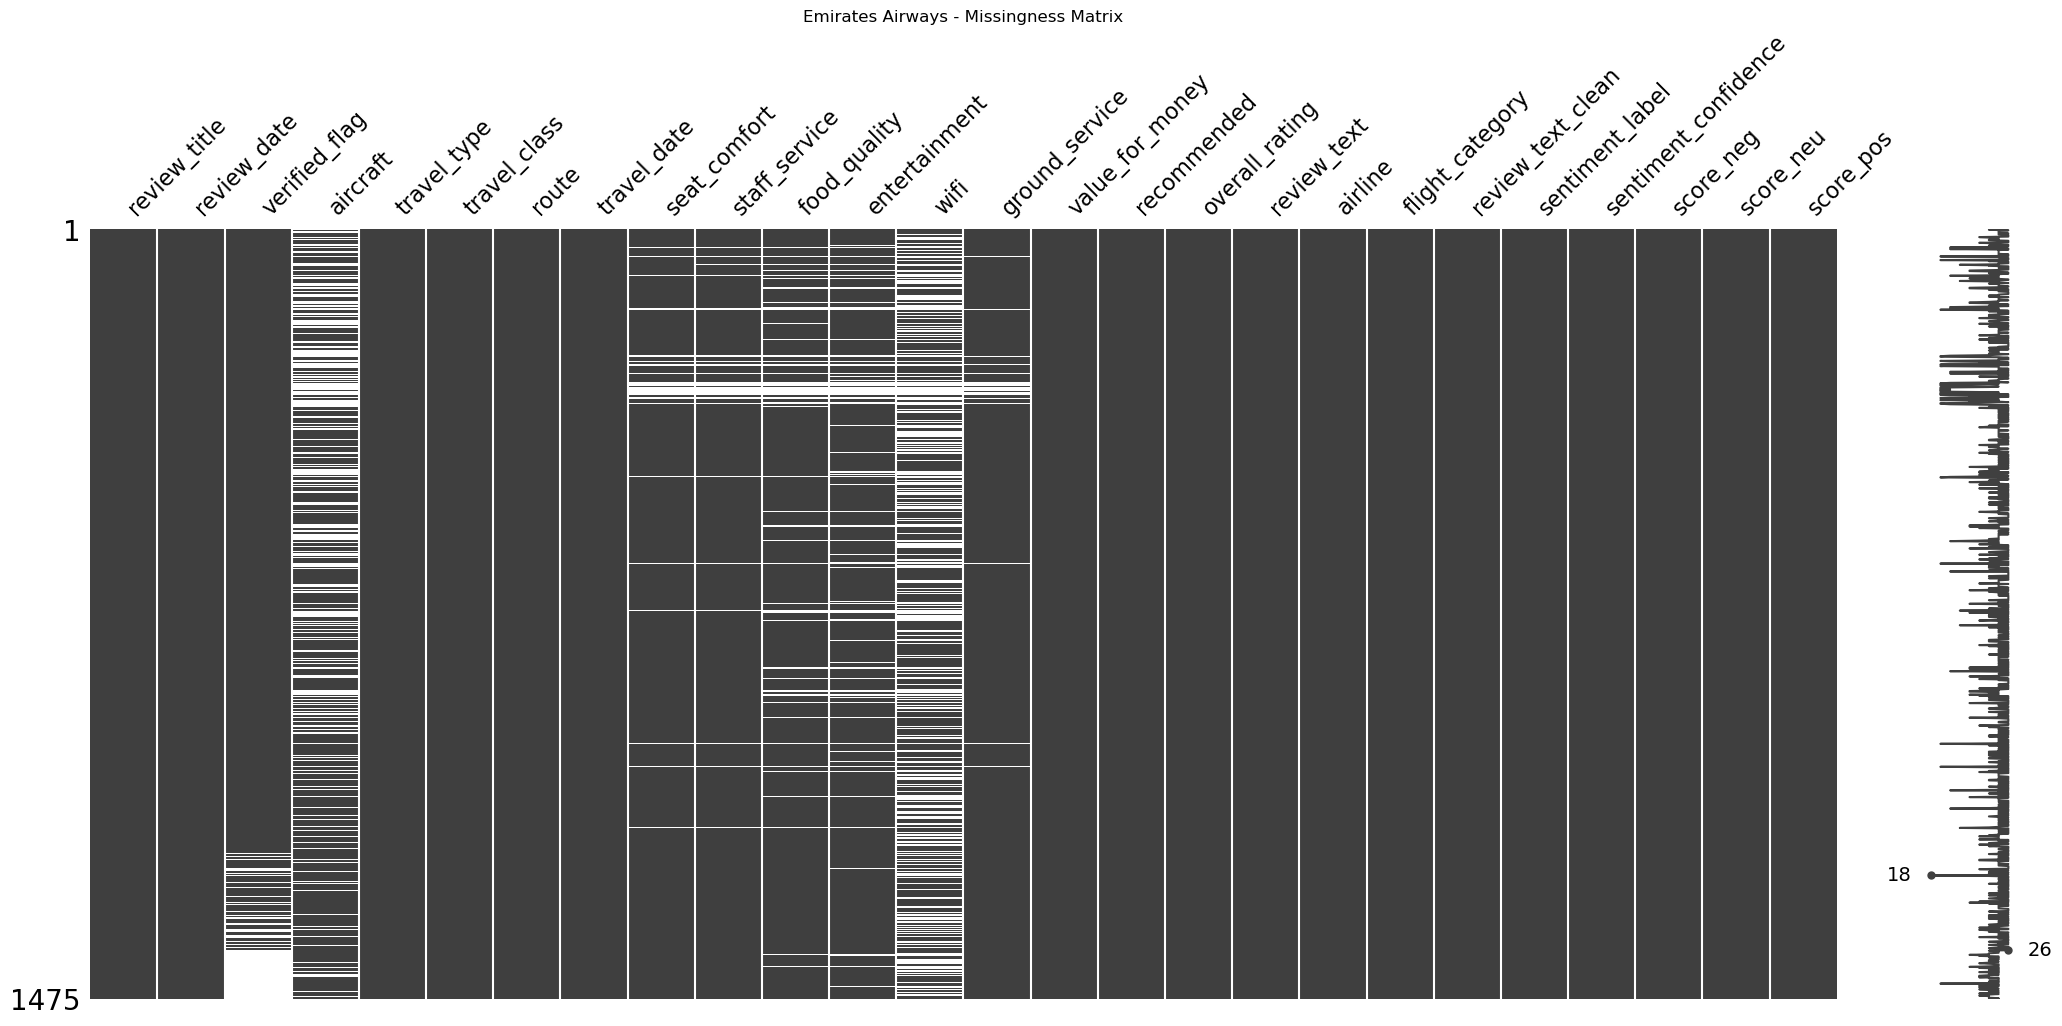

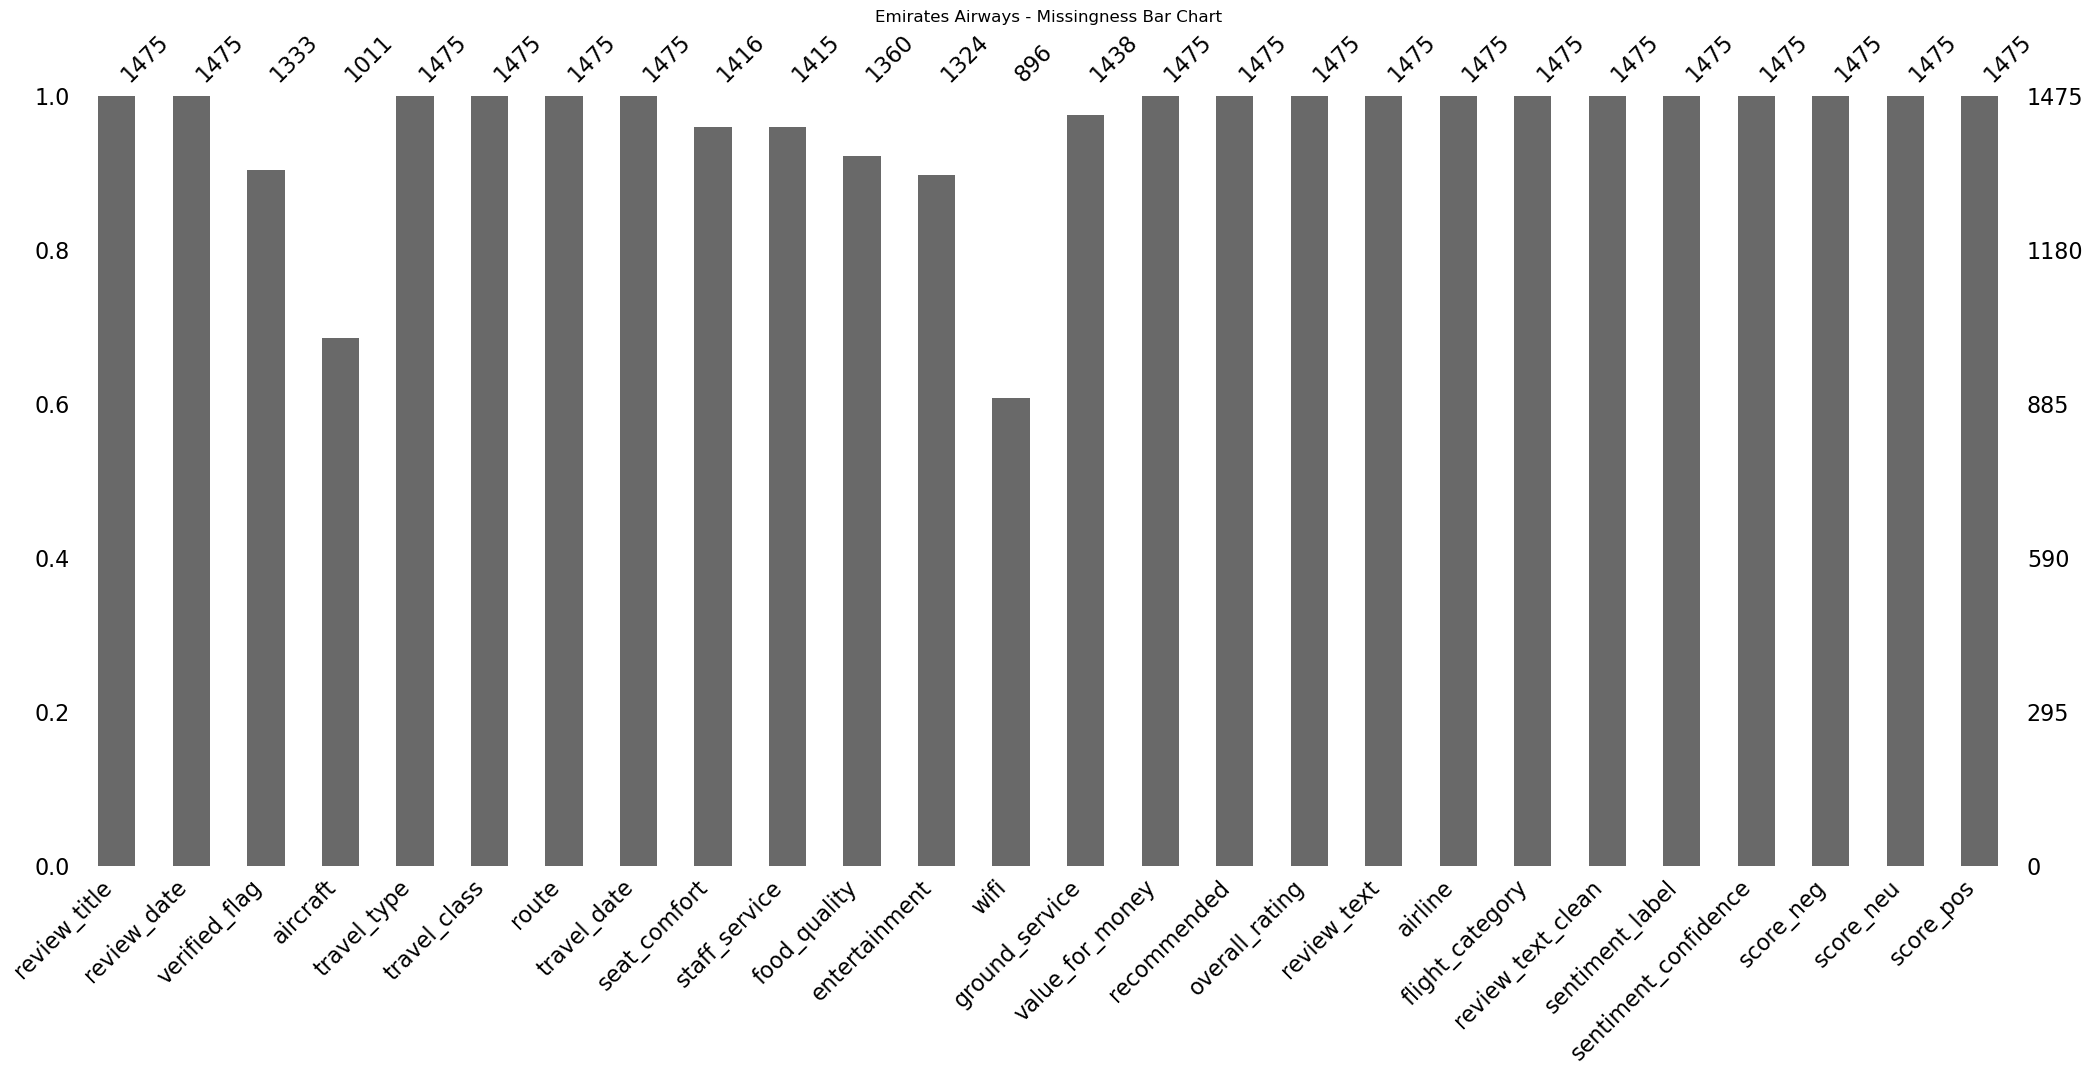

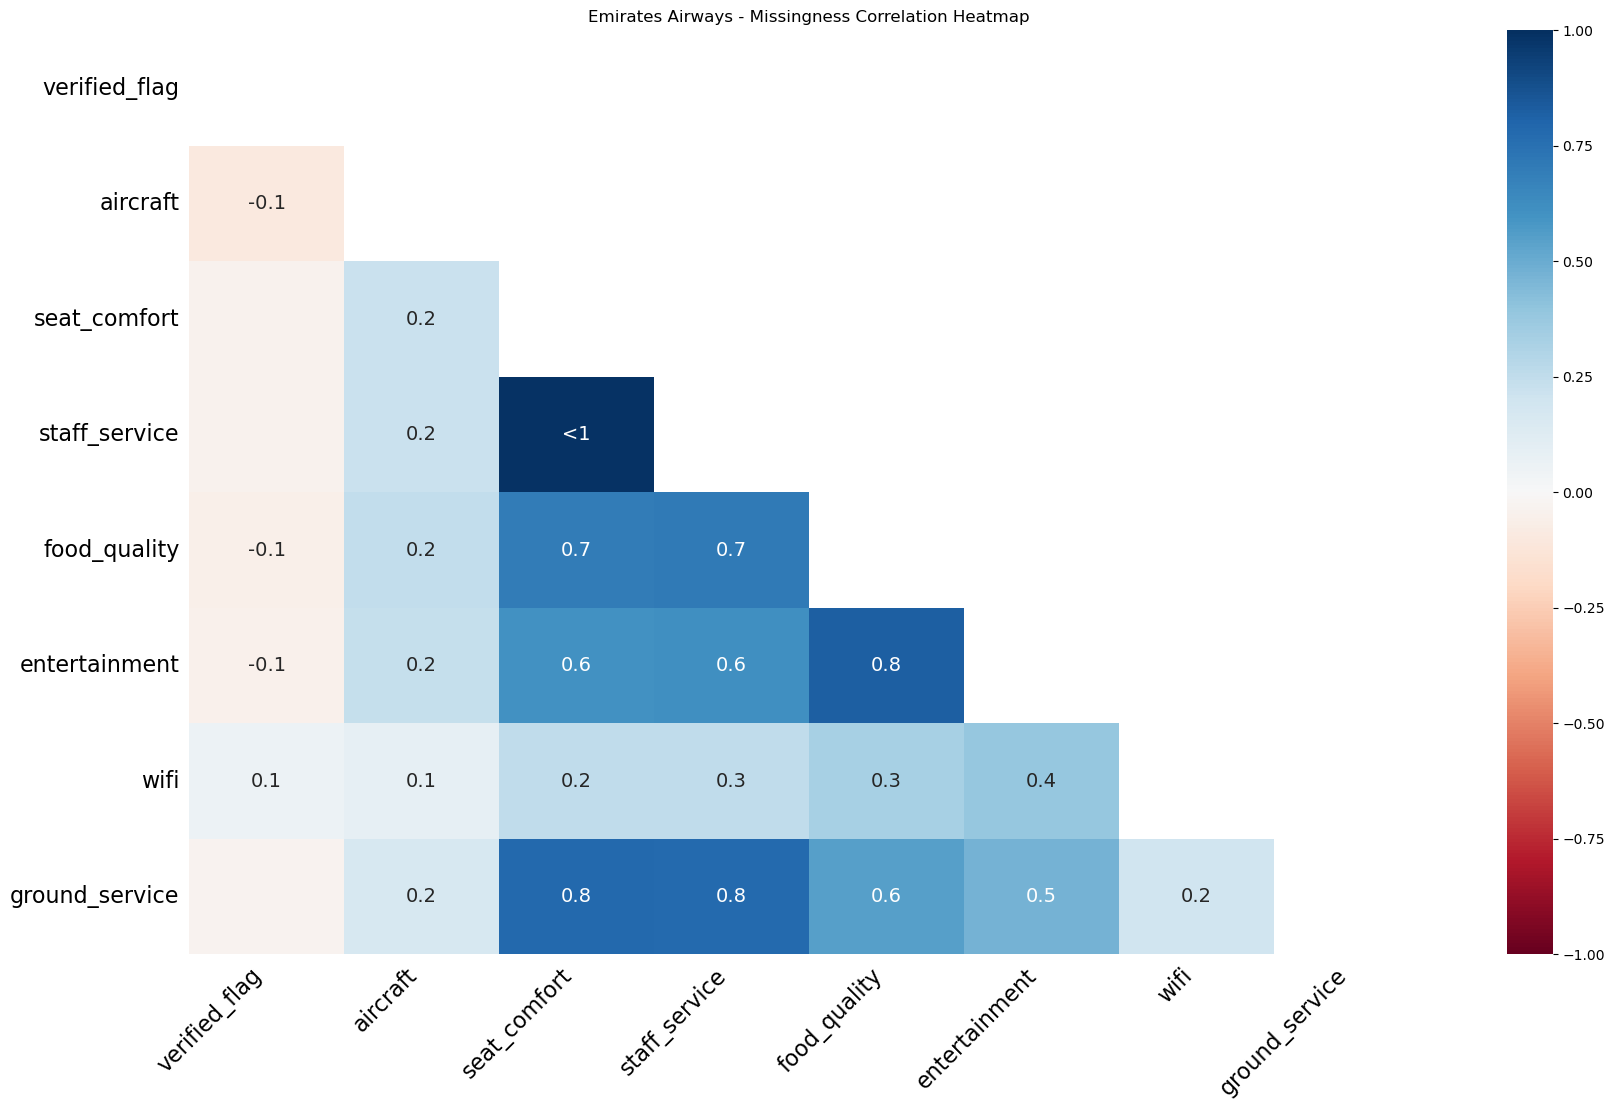

In [27]:
# Function to show missingness plots for a dataset
def plot_missingness(df, airline_name):
    print(f"\n--- Missingness for {airline_name} ---")
    print(df.isnull().sum().sort_values(ascending=False))
    
    # Black-and-white matrix plot
    msno.matrix(df)
    plt.title(f"{airline_name} - Missingness Matrix")
    plt.show()
    
    # Bar chart of % missing per column
    msno.bar(df)
    plt.title(f"{airline_name} - Missingness Bar Chart")
    plt.show()
    
    # Heatmap of missingness correlation (helps spot MAR patterns)
    msno.heatmap(df)
    plt.title(f"{airline_name} - Missingness Correlation Heatmap")
    plt.show()

# British Airways
plot_missingness(ba_df_filtered, "British Airways")

# Emirates Airways
plot_missingness(emirates_df_filtered, "Emirates Airways")

## 2] Missingness Diagnostics Tests:

**Tests performed:**  
- **Correlation Analysis** → correlation between missingness flags.  
- **Chi-Square Test of Independence** → association of missingness with categorical variables.  
- **Logistic Regression AUC Test** → predictability of missingness from other features.

Added binary flags for high-missing columns.  
Checked correlations between missingness flags (MAR signals).  
Ran χ² tests against key categoricals (SeatType, Traveller Type, Route, Recommended).  
Predicted missingness with logistic regression + AUC to test if it’s explainable (MCAR vs MAR).  

Thid Identified whether missingness is random or systematic, informing imputation strategy.  



In [23]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

# --- Load BA ---
ba = pd.read_csv(r"C:\BA_AirlineReviews.csv")

# === 0) Define columns ===
high_missing_cols = ["Wifi&Connectivity", "Aircraft", "InflightEntertainment", "GroundService"]

# columns that are free text / IDs we don't want in the model
free_text_cols = [c for c in ["ReviewBody","ReviewHeader","Name"] if c in ba.columns]

# date-like columns to drop from the classifier (can be used later if you parse to datetime parts)
date_like_cols = [c for c in ["Datetime","DateFlown","ReviewDate"] if c in ba.columns]

# === 1) Create missingness flags ===
for col in high_missing_cols:
    if col in ba.columns:
        ba[f"{col}_missing"] = ba[col].isna().astype(int)

# === 2) Correlation between missingness flags (quick MAR signal) ===
miss_flags = [f"{c}_missing" for c in high_missing_cols if f"{c}_missing" in ba.columns]
print("\n--- Missingness Correlations (BA) ---")
print(ba[miss_flags].corr())

# === 3) Chi-square tests with key categoricals ===
categorical_cols_to_test = [c for c in ["SeatType","TypeOfTraveller","Route","Recommended"] if c in ba.columns]
for col in high_missing_cols:
    flag = f"{col}_missing"
    if flag in ba.columns:
        print(f"\n--- Chi-Square Tests for {flag} ---")
        for cat in categorical_cols_to_test:
            # build contingency only on non-null cat values
            cont = pd.crosstab(ba[flag], ba[cat], dropna=True)
            if cont.shape[1] >= 2:
                chi2, p, dof, _ = chi2_contingency(cont)
                print(f"{cat}: p={p:.6f}  (chi2={chi2:.1f}, dof={dof})")

# === 4) Logistic-regression predictability of missingness ===
def missingness_predictability(df: pd.DataFrame, target_flag: str) -> float:
    """Return AUC for predicting target_flag from other observed columns."""

    # Start from full frame
    X = df.copy()

    # Drop target and its source columns to avoid leakage
    src_col = target_flag.replace("_missing","")
    drop_cols = [target_flag] + [c for c in high_missing_cols if c in X.columns] + free_text_cols + date_like_cols
    if src_col in X.columns:  # drop the raw score column too
        drop_cols.append(src_col)
    X = X.drop(columns=[c for c in drop_cols if c in X.columns])

    y = df[target_flag].astype(int)

    # Identify numeric vs categorical
    numeric_cols = X.select_dtypes(include=["number","bool"]).columns.tolist()
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    # Build preprocessors
    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        # no scaler needed for logistic with many dummies; fine to omit
    ])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),        # fill NaN first
        ("to_str", FunctionTransformer(lambda a: a.astype(str))),# force uniform string dtype
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])

    pre = ColumnTransformer([
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ])

    clf = Pipeline([
        ("pre", pre),
        ("lr", LogisticRegression(max_iter=1000))
    ])

    clf.fit(X, y)
    y_prob = clf.predict_proba(X)[:,1]
    auc = roc_auc_score(y, y_prob)
    return auc

print("\n--- Predictability (AUC) of Missingness Flags ---")
for flag in miss_flags:
    auc = missingness_predictability(ba, flag)
    print(f"{flag}: AUC = {auc:.3f}")


--- Missingness Correlations (BA) ---
                               Wifi&Connectivity_missing  Aircraft_missing  \
Wifi&Connectivity_missing                       1.000000          0.079834   
Aircraft_missing                                0.079834          1.000000   
InflightEntertainment_missing                   0.216095         -0.055837   
GroundService_missing                           0.239850          0.547780   

                               InflightEntertainment_missing  \
Wifi&Connectivity_missing                           0.216095   
Aircraft_missing                                   -0.055837   
InflightEntertainment_missing                       1.000000   
GroundService_missing                              -0.257042   

                               GroundService_missing  
Wifi&Connectivity_missing                   0.239850  
Aircraft_missing                            0.547780  
InflightEntertainment_missing              -0.257042  
GroundService_missing        

C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wifi&Connectivity_missing: AUC = 0.910


C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Aircraft_missing: AUC = 0.930


C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


InflightEntertainment_missing: AUC = 0.929
GroundService_missing: AUC = 0.994


C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

# ---------- USE YOUR CURRENT DF ----------
# ba_df already loaded
df = ba_df.copy()   # swap to emirates_df.copy() for Emirates

# ---------- 0) DEFINE ----------
high_missing_cols = ["wifi","aircraft","entertainment","ground_service"]
free_text_cols = [c for c in ["review_text","review_title","name"] if c in df.columns]
date_like_cols = [c for c in ["review_date","travel_date","datetime"] if c in df.columns]

# ---------- 1) FLAGS ----------
for col in high_missing_cols:
    if col in df.columns:
        df[f"{col}_missing"] = df[col].isna().astype(int)

miss_flags = [f"{c}_missing" for c in high_missing_cols if f"{c}_missing" in df.columns]

print("\n--- % Missing ---")
print((df[high_missing_cols].isna().mean()*100).round(2).sort_values(ascending=False))

print("\n--- Missingness Correlations (flags) ---")
print(df[miss_flags].corr().round(3))

# ---------- 2) CHI-SQUARE vs categoricals ----------
cats_to_test = [c for c in ["travel_class","travel_type","flight_category","route","recommended","airline"] if c in df.columns]
print("\n--- Chi-Square tests (flag ~ categoricals) ---")
for flag in miss_flags:
    print(f"\n{flag}:")
    for cat in cats_to_test:
        topN = df[cat].value_counts().nlargest(25).index
        cont = pd.crosstab(df[flag], df[cat].where(df[cat].isin(topN), other="OTHER"), dropna=True)
        if cont.shape[1] >= 2:
            chi2, p, dof, _ = chi2_contingency(cont)
            print(f"  {cat:16s}  p={p:.6f}  (chi2={chi2:.1f}, dof={dof})")

# ---------- 3) PREDICTABILITY (AUC) ----------
def missingness_auc(df_in: pd.DataFrame, target_flag: str) -> float:
    """Predict target_flag using other observed columns (no leakage); return AUC."""
    X = df_in.copy()
    y = df_in[target_flag].astype(int)

    # drop target & sources to prevent leakage
    src_col = target_flag.replace("_missing","")
    drop_cols = [target_flag] + high_missing_cols + free_text_cols + date_like_cols
    if src_col in X.columns:
        drop_cols.append(src_col)
    X = X.drop(columns=[c for c in drop_cols if c in X.columns])

    # split numeric / categorical
    num_cols = X.select_dtypes(include=["number","bool"]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    # **Coerce categoricals to string BEFORE encoding**
    X_num = X[num_cols].copy()
    for c in num_cols:
        X_num[c] = X_num[c].fillna(X_num[c].median())

    X_cat = X[cat_cols].copy()
    # robust coercion even if some cells are sequences/objects
    X_cat = X_cat.astype("string").fillna("MISSING").astype(str)

    pre = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])

    clf = Pipeline([
        ("pre", pre),
        ("lr", LogisticRegression(max_iter=2000))
    ])

    # fit on pre-imputed numeric + coerced categorical
    X_model = pd.concat([X_num, X_cat], axis=1)
    clf.fit(X_model, y)
    y_prob = clf.predict_proba(X_model)[:, 1]
    return roc_auc_score(y, y_prob)

print("\n--- Predictability (AUC) of Missingness Flags ---")
for flag in miss_flags:
    auc = missingness_auc(df, flag)
    print(f"{flag}: AUC = {auc:.3f}")



--- % Missing ---
wifi              81.08
aircraft          40.27
entertainment     35.43
ground_service    11.28
dtype: float64

--- Missingness Correlations (flags) ---
                        wifi_missing  aircraft_missing  entertainment_missing  \
wifi_missing                   1.000             0.012                  0.272   
aircraft_missing               0.012             1.000                  0.048   
entertainment_missing          0.272             0.048                  1.000   
ground_service_missing         0.170             0.406                 -0.124   

                        ground_service_missing  
wifi_missing                             0.170  
aircraft_missing                         0.406  
entertainment_missing                   -0.124  
ground_service_missing                   1.000  

--- Chi-Square tests (flag ~ categoricals) ---

wifi_missing:
  travel_class      p=0.355454  (chi2=4.4, dof=4)
  travel_type       p=0.000000  (chi2=97.6, dof=4)
  flight_cate

C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


wifi_missing: AUC = 0.970


C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


aircraft_missing: AUC = 0.955


C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


entertainment_missing: AUC = 0.984
ground_service_missing: AUC = 1.000


C:\Users\Samiksha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [176]:
analyze_missingness_cont(ba_selected, "wifi_score")

Kruskal-Wallis test (distance_km vs wifi_score_missing): p-value = 0.0000
Median distance (missing=1): 5539.907898416057
Median distance (missing=0): 6731.476835994467


# 3]  Logistic Regression Test for Missingness  

- Fits a logistic regression predicting whether a variable is missing (1) or observed (0) using travel-related predictors.  
- Interpretation of results:  
  - **All predictors not significant → MCAR**  
  - **One or more predictors significant → MAR**  



- **MCAR (Missing Completely at Random):**  
  - None of the predictors are significant (all p-values > 0.05).  
  - Missingness cannot be explained by observed variables.  

- **MAR (Missing At Random):**  
  - One or more predictors are significant (p < 0.05).  
  - Missingness is systematically related to observed variables (e.g., more missing in certain travel classes).  

- **MNAR (Missing Not At Random):**  
  - Harder to prove directly.  
  - Suspected if missingness is predictable but not well explained by observed features (requires domain logic or external info).  

- # British Airways Logistic Regression Test

In [181]:
def analyze_missingness_logit(df, var):
    df[f"{var}_missing"] = df[var].isna().astype(int)
    y = df[f"{var}_missing"]

    features = ["travel_class", "flight_category", "distance_km",
                "travel_type_Business", "travel_type_Couple", 
                "travel_type_Family", "travel_type_Solo", "travel_type_Unknown"]
    
    # Build feature matrix
    X = df[features].copy()
    X = pd.get_dummies(X, drop_first=True)  # for travel_class if categorical
    
    # Drop rows with missing predictors
    mask = X.notna().all(axis=1)
    X = X[mask]
    y = y[mask]

    logit = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
    print(logit.summary())

In [ ]:
## Wifi Sco

In [182]:
analyze_missingness_logit(ba_selected, "wifi_score")

                           Logit Regression Results                           
Dep. Variable:     wifi_score_missing   No. Observations:                 2923
Model:                          Logit   Df Residuals:                     2915
Method:                           MLE   Df Model:                            7
Date:                Sun, 17 Aug 2025   Pseudo R-squ.:                 0.02459
Time:                        11:08:02   Log-Likelihood:                -1456.5
converged:                      False   LL-Null:                       -1493.2
Covariance Type:            nonrobust   LLR p-value:                 2.966e-13
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.2974        nan        nan        nan         nan         nan
travel_class             0.0014      0.047      0.030      0.976      -0.090       0.093
flight_categ

C:\Users\Samiksha\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Entertainment

In [183]:
analyze_missingness(ba_selected, "entertainment_score")


==== Analyzing missingness for entertainment_score ====
Overall missingness: 35.43%

Missingness by travel_class:
travel_class
1    0.427570
3    0.354455
2    0.112903
4    0.080645
Name: entertainment_score_missing, dtype: float64
Chi² test p-value: 0.0000

Missingness by flight_category:
flight_category
1    0.823916
2    0.717884
3    0.126346
0    0.016949
Name: entertainment_score_missing, dtype: float64
Chi² test p-value: 0.0000


In [184]:
analyze_missingness_cont(ba_selected, "entertainment_score")

Kruskal-Wallis test (distance_km vs entertainment_score_missing): p-value = 0.0000
Median distance (missing=1): 1434.022288578857
Median distance (missing=0): 7212.082054225986


In [185]:
analyze_missingness_logit(ba_selected, "entertainment_score")

                                Logit Regression Results                               
Dep. Variable:     entertainment_score_missing   No. Observations:                 2923
Model:                                   Logit   Df Residuals:                     2915
Method:                                    MLE   Df Model:                            7
Date:                         Sun, 17 Aug 2025   Pseudo R-squ.:                  0.3420
Time:                                 11:25:44   Log-Likelihood:                -1284.7
converged:                                True   LL-Null:                       -1952.5
Covariance Type:                     nonrobust   LLR p-value:                3.353e-284
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.8397        nan        nan        nan         nan         nan
travel_class            -0.03

## Food Quality

In [186]:
analyze_missingness(ba_selected, "food_quality")


==== Analyzing missingness for food_quality ====
Overall missingness: 11.96%

Missingness by travel_class:
travel_class
1    0.176986
2    0.067742
3    0.056436
4    0.021505
Name: food_quality_missing, dtype: float64
Chi² test p-value: 0.0000

Missingness by flight_category:
flight_category
1    0.262812
2    0.163728
3    0.066289
0    0.010169
Name: food_quality_missing, dtype: float64
Chi² test p-value: 0.0000


In [187]:
analyze_missingness_cont(ba_selected, "food_quality")

Kruskal-Wallis test (distance_km vs food_quality_missing): p-value = 0.0000
Median distance (missing=1): 1463.031401799209
Median distance (missing=0): 6295.001463141813


In [188]:
analyze_missingness_logit(ba_selected, "food_quality")

                            Logit Regression Results                            
Dep. Variable:     food_quality_missing   No. Observations:                 2923
Model:                            Logit   Df Residuals:                     2915
Method:                             MLE   Df Model:                            7
Date:                  Sun, 17 Aug 2025   Pseudo R-squ.:                  0.1136
Time:                          11:28:25   Log-Likelihood:                -1004.5
converged:                         True   LL-Null:                       -1133.2
Covariance Type:              nonrobust   LLR p-value:                 7.404e-52
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8093   1.14e+07   7.09e-08      1.000   -2.24e+07    2.24e+07
travel_class            -0.5744      0.073     -7.906      0.000      -0.717      -0.

## Ground Service

In [189]:
analyze_missingness(ba_selected, "ground_service")


==== Analyzing missingness for ground_service ====
Overall missingness: 11.28%

Missingness by travel_class:
travel_class
4    0.161290
3    0.128713
2    0.125806
1    0.095794
Name: ground_service_missing, dtype: float64
Chi² test p-value: 0.0061

Missingness by flight_category:
flight_category
0    0.979661
1    0.027595
3    0.024929
2    0.022670
Name: ground_service_missing, dtype: float64
Chi² test p-value: 0.0000


In [190]:
analyze_missingness_cont(ba_selected, "ground_service")

Kruskal-Wallis test (distance_km vs ground_service_missing): p-value = 0.6816
Median distance (missing=1): 6550.4764353496685
Median distance (missing=0): 5707.286405145761


In [191]:
analyze_missingness_logit(ba_selected, "ground_service")

                             Logit Regression Results                             
Dep. Variable:     ground_service_missing   No. Observations:                 2923
Model:                              Logit   Df Residuals:                     2915
Method:                               MLE   Df Model:                            7
Date:                    Sun, 17 Aug 2025   Pseudo R-squ.:                 0.02196
Time:                            11:32:12   Log-Likelihood:                -337.52
converged:                           True   LL-Null:                       -345.10
Covariance Type:                nonrobust   LLR p-value:                   0.03403
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.1044   2.05e+07  -1.02e-07      1.000   -4.03e+07    4.03e+07
travel_class            -0.2141      0.129     -1.663      0.096     

In [196]:
def analyze_missingness_logit(df, var):
    df[f"{var}_missing"] = df[var].isna().astype(int)
    y = df[f"{var}_missing"]

    features = ["travel_class", "flight_category", "distance_km",
                "travel_type_Business", "travel_type_Couple", 
                "travel_type_Family", "travel_type_Solo", "travel_type_Unknown"]
    
    X = df[features].copy()

    # Dummy encode travel_class if categorical
    if X["travel_class"].dtype == "object":
        X = pd.get_dummies(X, columns=["travel_class"], drop_first=True)
    
    # Drop constant columns
    X = X.loc[:, X.nunique() > 1]

    # Force numeric (fix dtype issue)
    X = X.apply(pd.to_numeric, errors="coerce")
    
    # Drop rows with missing predictors
    mask = X.notna().all(axis=1)
    X = X[mask]
    y = y[mask]

    try:
        logit = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
        print(logit.summary())
    except Exception as e:
        print(f"Logit failed: {e}")

- # Emirates Airways Logistic Regression Test
### Wifi

In [197]:
# Run categorical/group analysis
analyze_missingness(em_selected, "wifi_score")

# Run continuous (distance_km) check
analyze_missingness_cont(em_selected, "wifi_score")

# Run multivariate logistic regression
analyze_missingness_logit(em_selected, "wifi_score")


==== Analyzing missingness for wifi_score ====
Overall missingness: 39.25%

Missingness by travel_class:
travel_class
2    0.714286
1    0.410160
3    0.359116
4    0.186047
Name: wifi_score_missing, dtype: float64
Chi² test p-value: 0.0032

Missingness by flight_category:
flight_category
0    0.500000
1    0.400000
2    0.395683
3    0.391933
Name: wifi_score_missing, dtype: float64
Chi² test p-value: 0.9907
Kruskal-Wallis test (distance_km vs wifi_score_missing): p-value = 0.8502
Median distance (missing=1): 8878.301609607788
Median distance (missing=0): 8808.231119306614
                           Logit Regression Results                           
Dep. Variable:     wifi_score_missing   No. Observations:                 1473
Model:                          Logit   Df Residuals:                     1466
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Aug 2025   Pseudo R-squ.:                 0.01546
Time:                  

## Food Quality

In [198]:
# Run categorical/group analysis
analyze_missingness(em_selected, "food_quality")

# Run continuous (distance_km) check
analyze_missingness_cont(em_selected, "food_quality")

# Run multivariate logistic regression
analyze_missingness_logit(em_selected, "food_quality")



==== Analyzing missingness for food_quality ====
Overall missingness: 7.80%

Missingness by travel_class:
travel_class
2    0.142857
1    0.093133
4    0.046512
3    0.035912
Name: food_quality_missing, dtype: float64
Chi² test p-value: 0.0040

Missingness by flight_category:
flight_category
0    0.500000
3    0.079909
2    0.057554
1    0.050000
Name: food_quality_missing, dtype: float64
Chi² test p-value: 0.1093
Kruskal-Wallis test (distance_km vs food_quality_missing): p-value = 0.0228
Median distance (missing=1): 9843.169592037744
Median distance (missing=0): 8694.114065247026
                            Logit Regression Results                            
Dep. Variable:     food_quality_missing   No. Observations:                 1473
Model:                            Logit   Df Residuals:                     1466
Method:                             MLE   Df Model:                            6
Date:                  Sun, 17 Aug 2025   Pseudo R-squ.:                 0.02464
Time: 

## Entertainment Score

In [199]:
# Run categorical/group analysis
analyze_missingness(em_selected, "entertainment_score")

# Run continuous (distance_km) check
analyze_missingness_cont(em_selected, "entertainment_score")

# Run multivariate logistic regression
analyze_missingness_logit(em_selected, "entertainment_score")


==== Analyzing missingness for entertainment_score ====
Overall missingness: 10.24%

Missingness by travel_class:
travel_class
2    0.142857
1    0.119473
4    0.069767
3    0.055249
Name: entertainment_score_missing, dtype: float64
Chi² test p-value: 0.0052

Missingness by flight_category:
flight_category
0    0.500000
3    0.101979
2    0.100719
1    0.100000
Name: entertainment_score_missing, dtype: float64
Chi² test p-value: 0.3275
Kruskal-Wallis test (distance_km vs entertainment_score_missing): p-value = 0.0236
Median distance (missing=1): 9629.641287922172
Median distance (missing=0): 8694.114065247026
                                Logit Regression Results                               
Dep. Variable:     entertainment_score_missing   No. Observations:                 1473
Model:                                   Logit   Df Residuals:                     1466
Method:                                    MLE   Df Model:                            6
Date:                         

### Ground Service

In [200]:
# Run categorical/group analysis
analyze_missingness(em_selected, "ground_service")

# Run continuous (distance_km) check
analyze_missingness_cont(em_selected, "ground_service")

# Run multivariate logistic regression
analyze_missingness_logit(em_selected, "ground_service")



==== Analyzing missingness for ground_service ====
Overall missingness: 2.51%

Missingness by travel_class:
travel_class
1    0.031985
3    0.008287
2    0.000000
4    0.000000
Name: ground_service_missing, dtype: float64
Chi² test p-value: 0.0567

Missingness by flight_category:
flight_category
0    0.500000
3    0.025875
2    0.014388
1    0.000000
Name: ground_service_missing, dtype: float64
Chi² test p-value: 0.0002
Kruskal-Wallis test (distance_km vs ground_service_missing): p-value = 0.2254
Median distance (missing=1): 9740.410265875405
Median distance (missing=0): 8799.847623646778
                             Logit Regression Results                             
Dep. Variable:     ground_service_missing   No. Observations:                 1473
Model:                              Logit   Df Residuals:                     1466
Method:                               MLE   Df Model:                            6
Date:                    Sun, 17 Aug 2025   Pseudo R-squ.:             